# EURUSD exchange forecasting

From: https://towardsdatascience.com/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python-6ceee9c6c651

Time Series is a collection of data points indexed based on the time they were collected. Most often, the data is recorded at regular time intervals. What makes Time Series data special?

Forecasting future Time Series values is a quite common problem in practice. Predicting the weather for the next week, the price of Bitcoins tomorrow, the number of your sales during Chrismas and future heart failure are common examples.

Time Series data introduces a “hard dependency” on previous time steps, so the assumption that independence of observations doesn’t hold. What are some of the properties that a Time Series can have?

**Stationarity**, **seasonality**, and **autocorrelation** are some of the properties of the Time Series you might be interested in.

A Times Series is said to be **stationary** when the mean and variance remain constant over time. A Time-Series has a trend if the mean is varying over time. Often you can eliminate it and make the series stationary by applying log transformation(s).

**Seasonality** refers to the phenomenon of variations at specific time-frames. eg people buying more Christmas trees during Christmas (who would’ve thought). A common approach to eliminating seasonality is to use differencing.

**Autocorrelation** refers to the correlation between the current value with a copy from a previous time (lag).
Why we would want to seasonality, trend and have a stationary Time Series? This is required data preprocessing step for Time Series forecasting with classical methods like ARIMA models. Luckily, we’ll do our modeling using Recurrent Neural Networks.

In [115]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

!dir

 El volumen de la unidad D es Datos
 El n£mero de serie del volumen es: F68D-348F

 Directorio de D:\Juano\Desktop\Postgrado\2_(2020-1)\data mining\LSTM

11/03/2020  02:01 p.m.    <DIR>          .
11/03/2020  02:01 p.m.    <DIR>          ..
06/03/2020  11:40 a.m.    <DIR>          .ipynb_checkpoints
11/03/2020  02:01 p.m.           839.592 eurusd.ipynb
06/03/2020  11:46 a.m.            74.699 exchange.csv
06/03/2020  11:14 a.m.         2.210.806 lstm_1step.ipynb
06/03/2020  11:31 a.m.         2.568.625 lstm_n_step.ipynb
               4 archivos      5.693.722 bytes
               3 dirs  1.251.583.623.168 bytes libres


## Load the data from the csv file

Load the data and separate out the the date column.

In [116]:
pairs = pd.read_csv('exchange.csv')
date = pd.to_datetime(pairs['Date'])
pairs['Date'] = date
pairs.index = pairs['Date']
pairs = pairs.drop(['Date'], axis = 1)
pairs.head()

,EUR/USD Close,USD/JPY Close,USD/CAD Close,EUR/JPY Close
Date,,,,
2013-01-01,1.3219,86.700,0.9934,114.470
2013-01-02,1.3177,87.203,0.9857,114.920
2013-01-03,1.3050,87.250,0.9878,113.884
2013-01-04,1.3080,88.120,0.9869,115.260
2013-01-07,1.3106,87.770,0.9860,115.071


In [117]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(pairs.values)
s_pairs = scaler.transform(pairs.values)
pairs = pd.DataFrame(s_pairs, index=pairs.index, columns=pairs.columns)
pairs.head()

,EUR/USD Close,USD/JPY Close,USD/CAD Close,EUR/JPY Close
Date,,,,
2013-01-01,1.361860,-3.010707,-2.112019,-0.751567
2013-01-02,1.319679,-2.943590,-2.178796,-0.725199
2013-01-03,1.192131,-2.937319,-2.160584,-0.785904
2013-01-04,1.222260,-2.821232,-2.168389,-0.705276
2013-01-07,1.248372,-2.867934,-2.176194,-0.716351


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002235DD95FC8>,
      dtype=object)

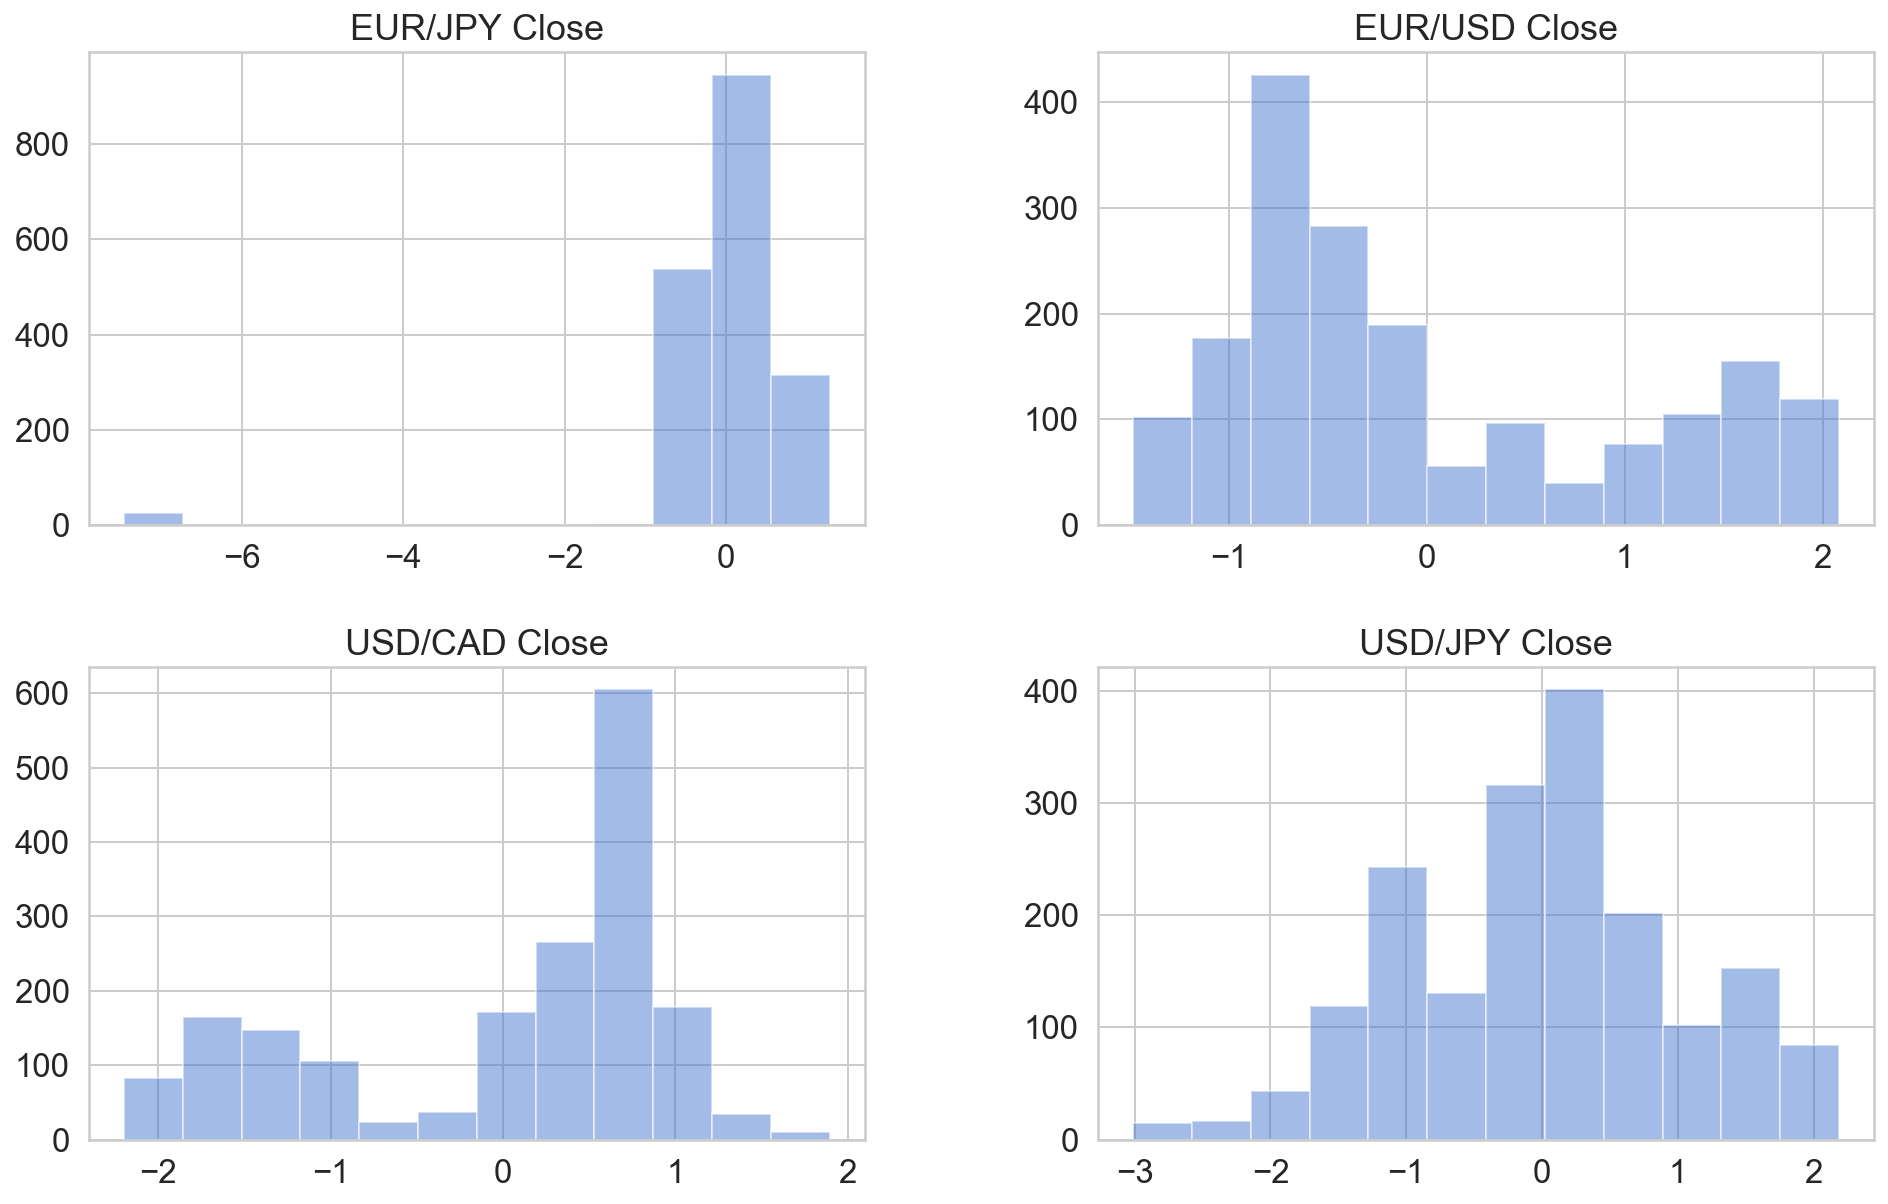

In [118]:
pairs.hist(bins=12, alpha=0.5)

# Filling the gaps
## Plot 

We have data from the last 7 years

https://towardsdatascience.com/how-to-interpolate-time-series-data-in-apache-spark-and-python-pandas-part-1-pandas-cff54d76a2ea
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html

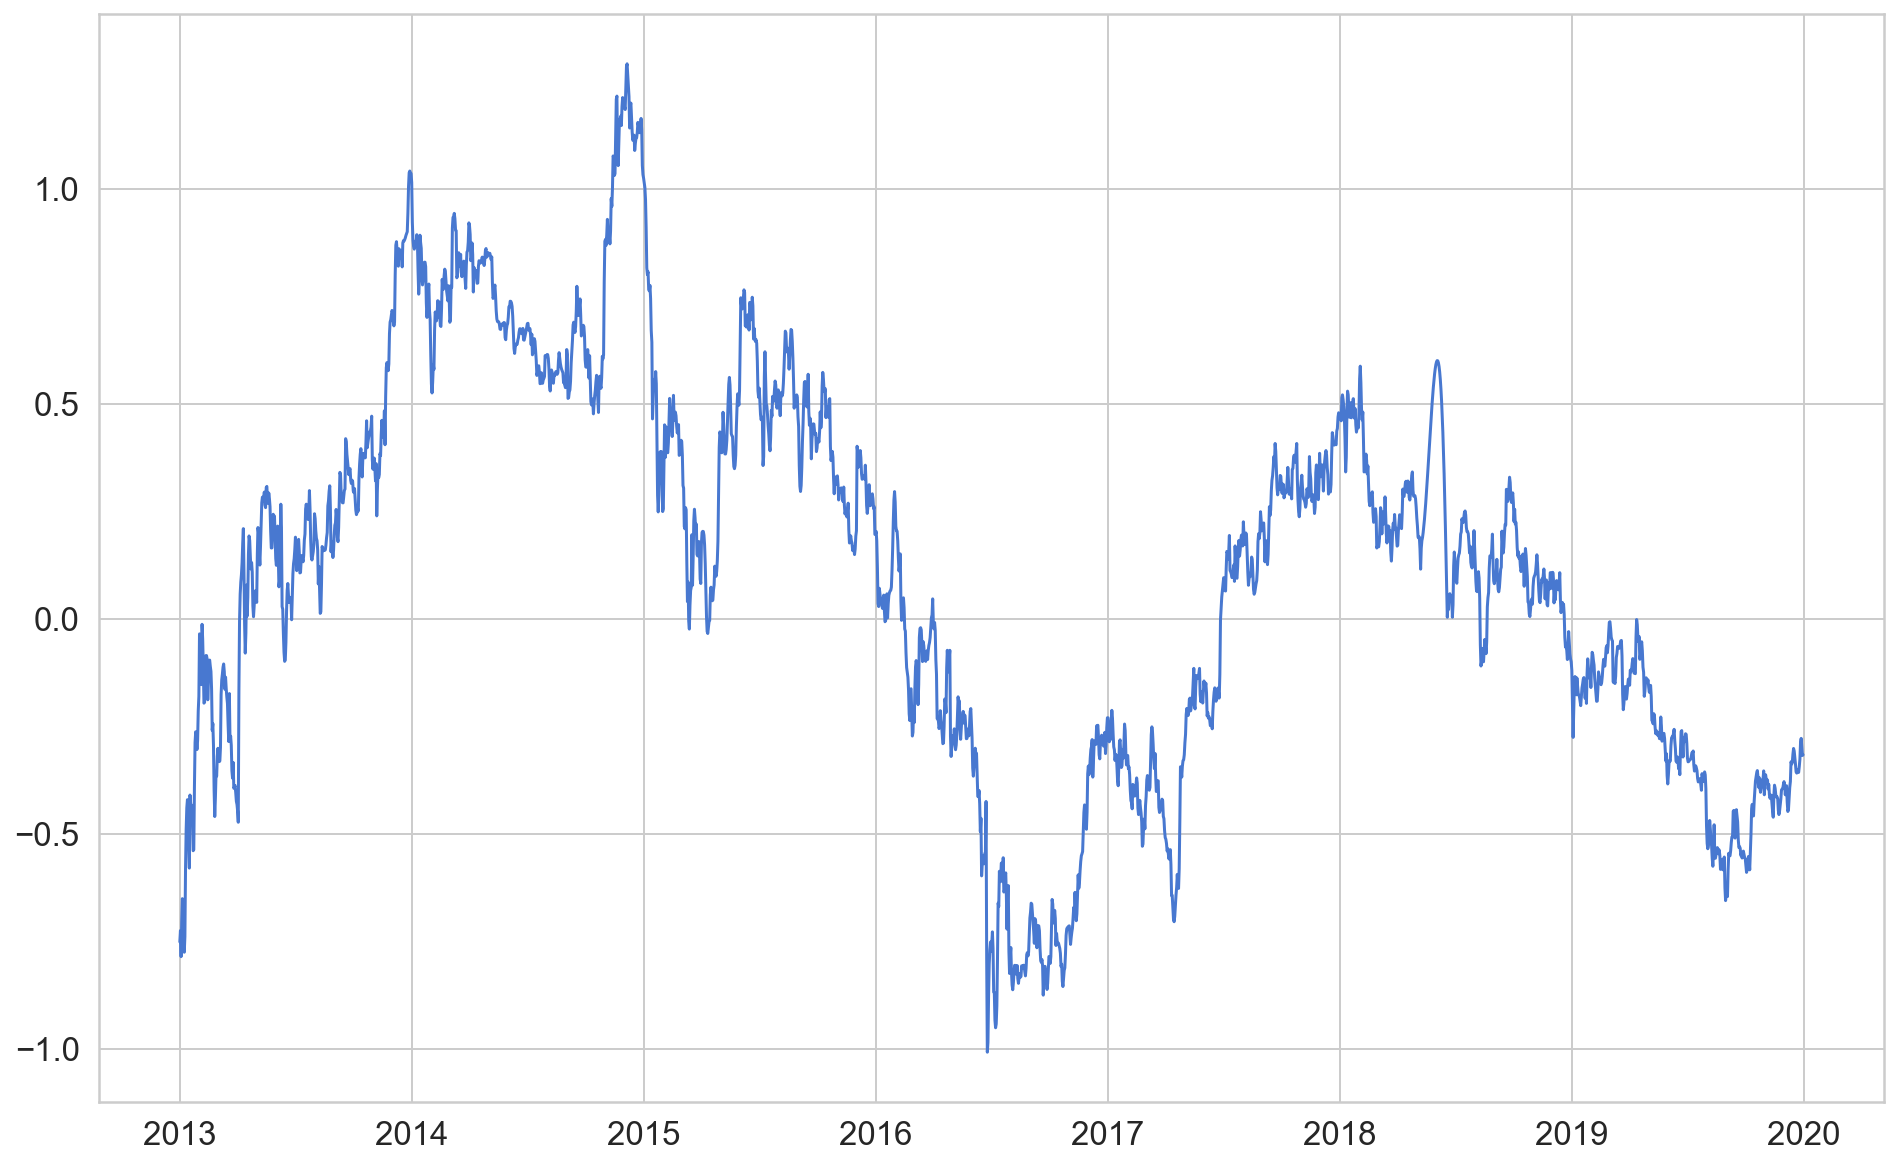

In [140]:
# plt.plot(date, pairs['EUR/USD Close'])
# plt.plot(date, pairs['USD/JPY Close'])
# plt.plot(date, pairs['USD/CAD Close'])
interpol = pairs.copy()
interpol[interpol['EUR/JPY Close'] < -6 ] = np.NaN
interpol = interpol.resample('D').interpolate(method='polynomial', order=3)
# interpol['EUR/JPY Close'].value_counts(dropna=False)  # Prints 26 NaN
plt.plot(interpol.index, interpol['EUR/JPY Close'])
plt.show()
pairs = interpol

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000223705ED048>,
      dtype=object)

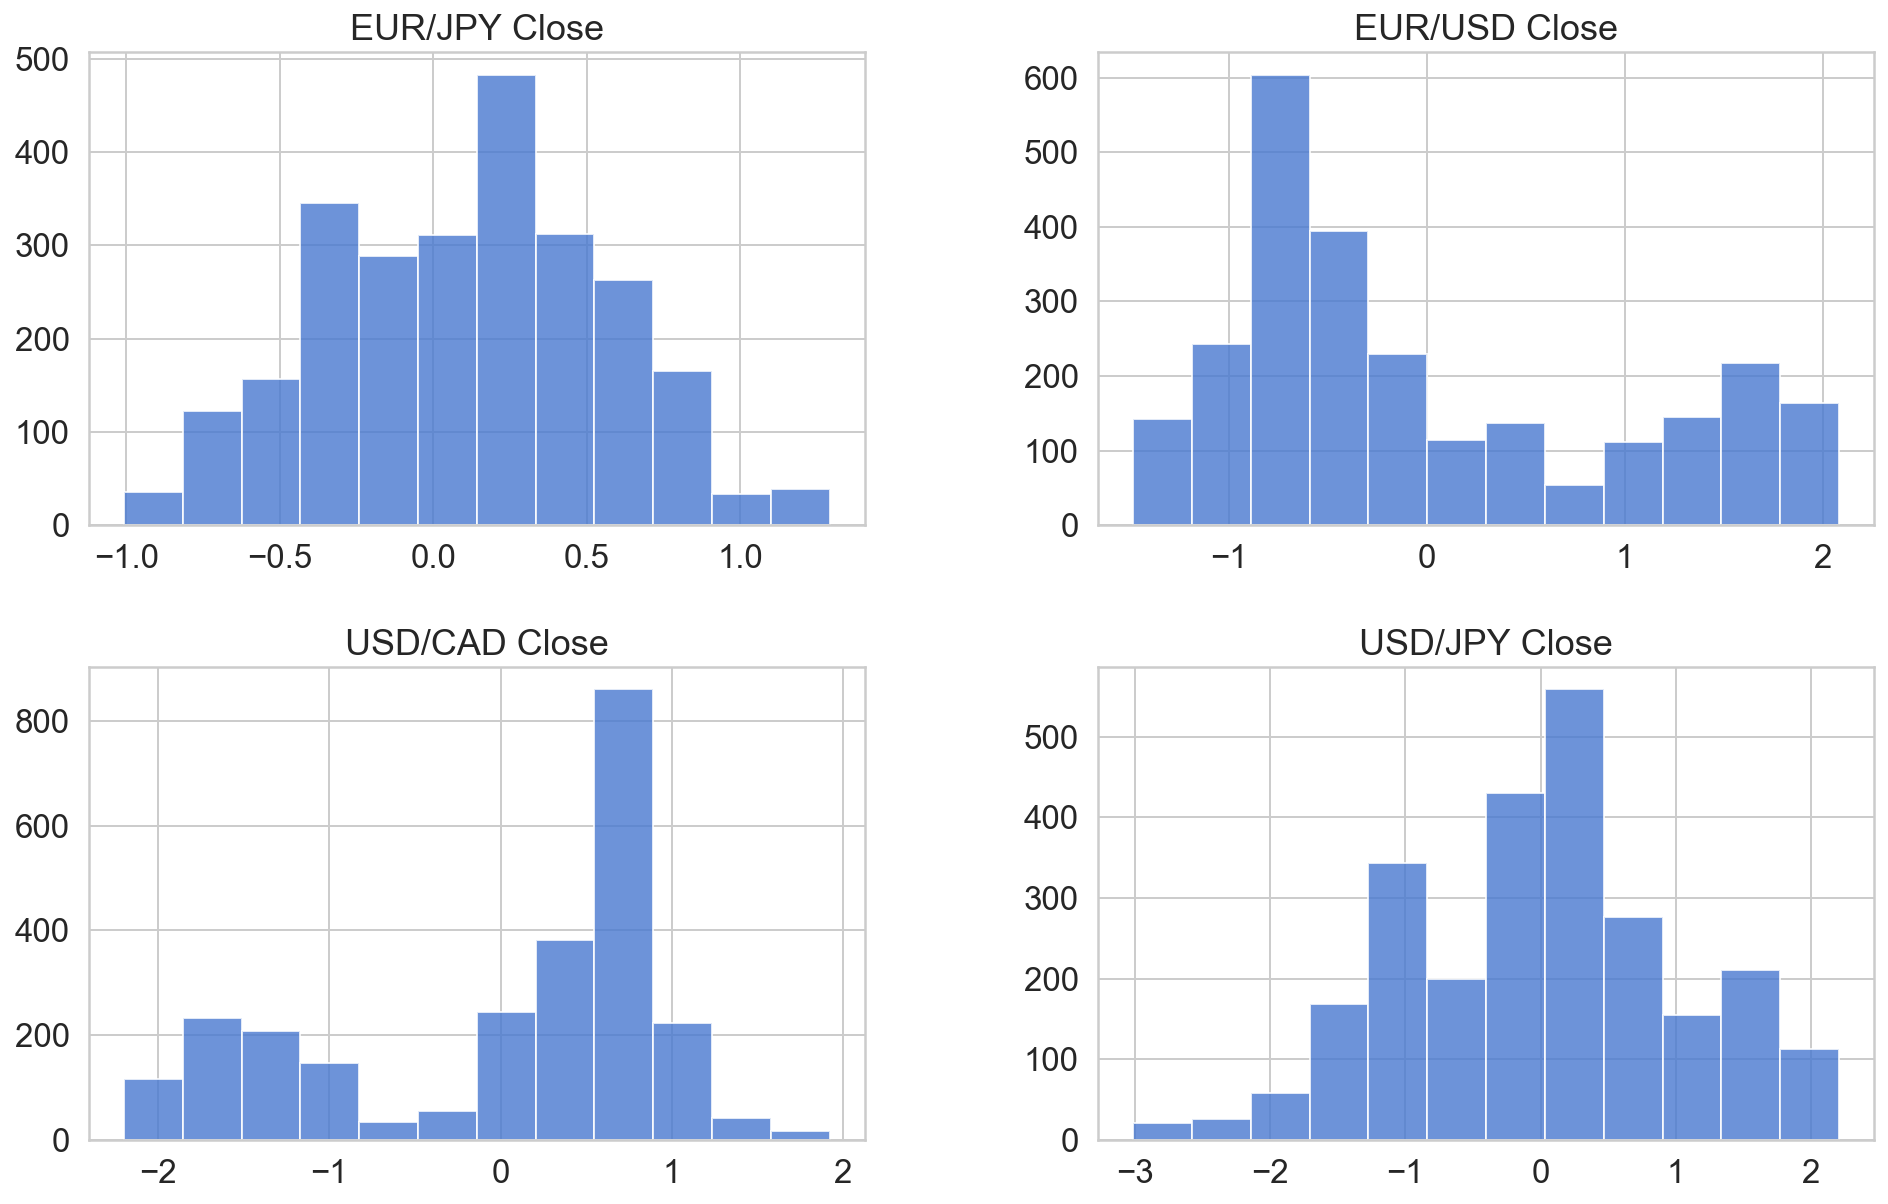

In [143]:
pairs.hist(bins=12, alpha=0.8)

## How it would looks two pairs. Is it any relation between them?

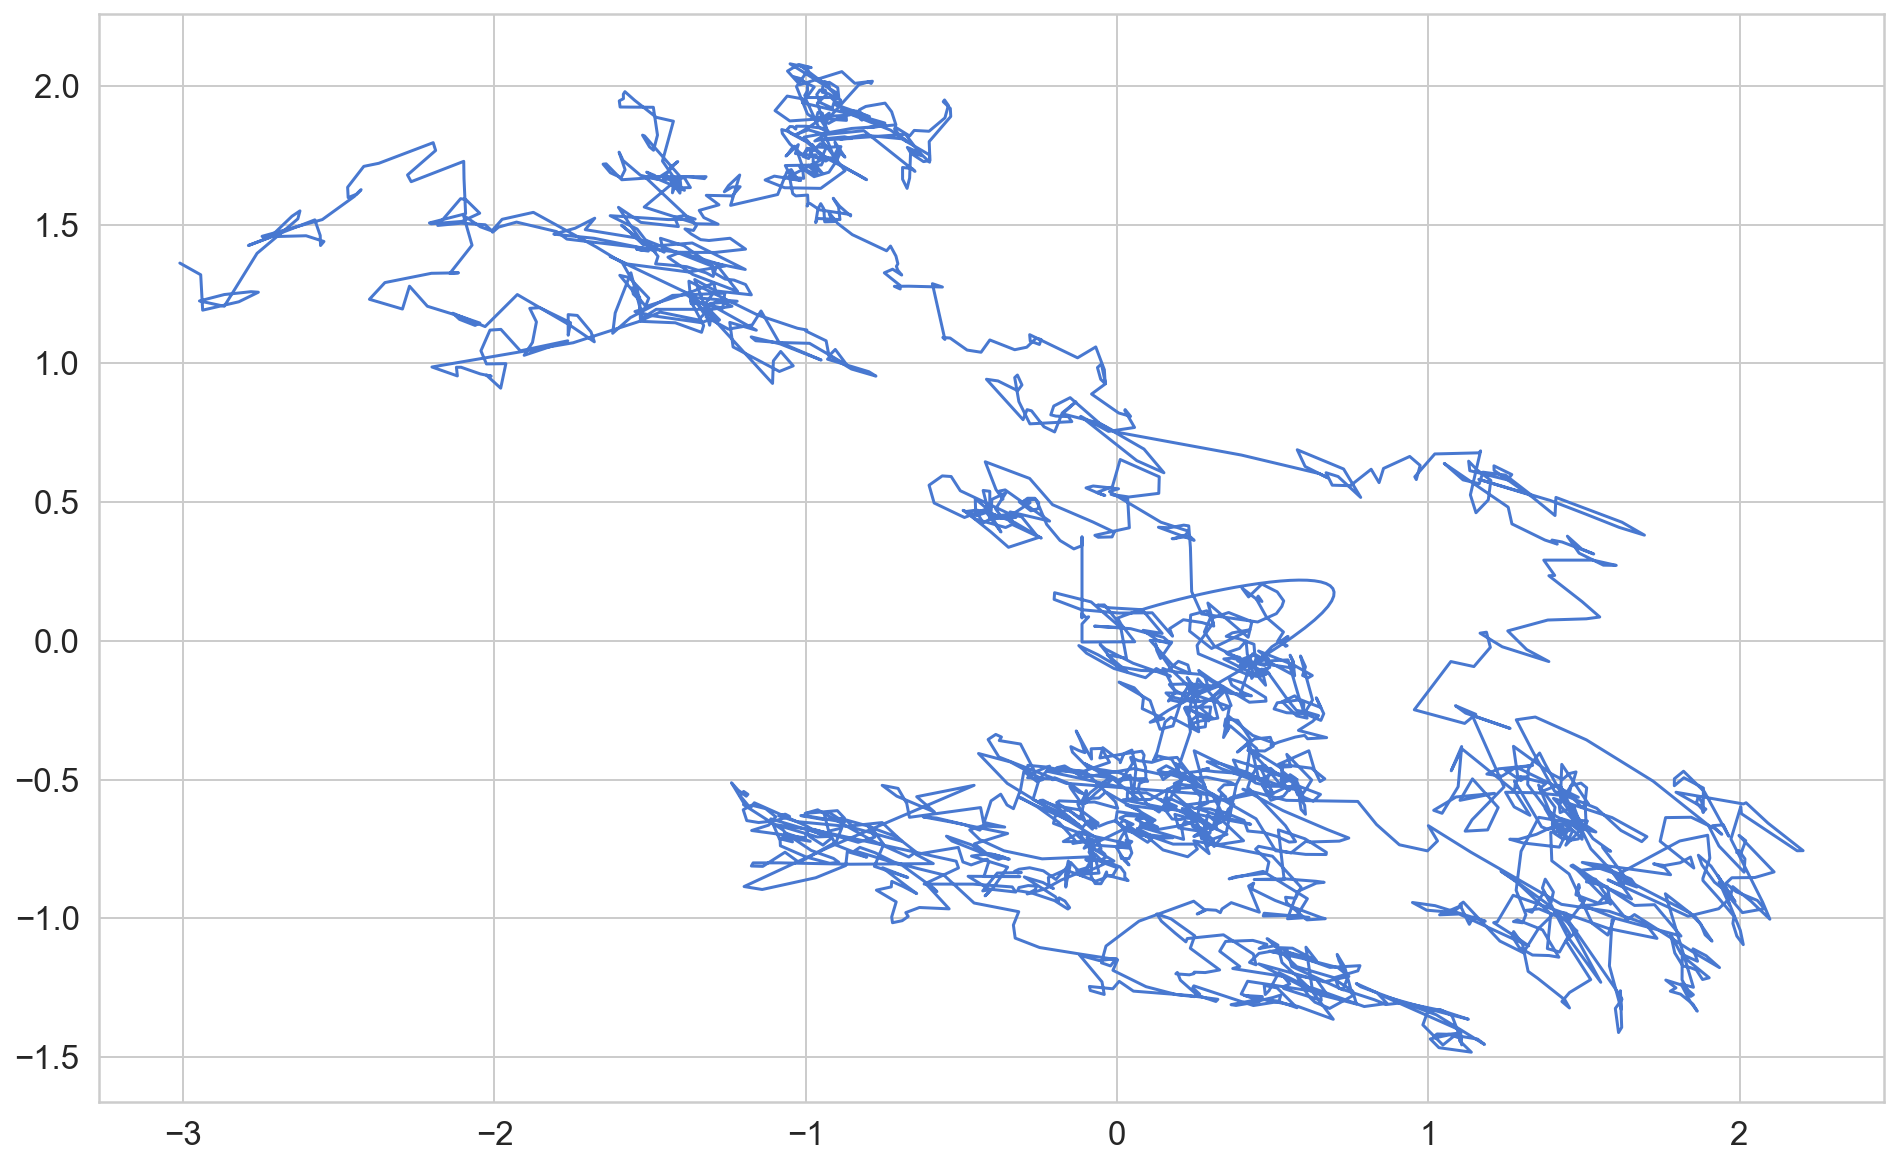

In [120]:
plt.plot(pairs['USD/JPY Close'], pairs['EUR/USD Close'])
plt.show()

## Predict the raw pair EURUSD

### Data Preprocessing

We need to “chop the data” into smaller sequences for our model. But first, we’ll split it into training and test data. For this model we will train with the first part of the sequence, and we will use the last part to test.

In [121]:
train_size = int(len(pairs) * 0.7)
test_size = len(pairs) - train_size
train, test = pairs.iloc[0 : train_size], pairs.iloc[train_size : len(pairs)]
print(len(train), len(test))

1789 767


Preparing the data for Time Series forecasting (LSTMs in particular) can be tricky. Intuitively, we need to predict the value at the current time step by using the history ( n time steps from it). Here’s a generic function that does the job:

The beauty of this function is that it works with univariate (single feature) and multivariate (multiple features) Time Series data. Let’s use a history of 10 time steps to make our sequences:

In [122]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

def create_dataset_nsteps(X, y, time_steps = 1, output_time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X) - 2 * time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps : i + time_steps + output_time_steps].values)
    return np.array(Xs), np.array(ys)

The beauty of this function is that it works with univariate (single feature) and multivariate (multiple features) Time Series data. Let’s use a history of 10 time steps to make our sequences:

In [123]:
input_time_steps = 5
output_time_steps = 1
target = 'EUR/USD Close';

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset_nsteps(train, train[target], input_time_steps, output_time_steps)
X_test, y_test = create_dataset_nsteps(test, test[target], input_time_steps, output_time_steps)

print(X_train.shape, y_train.shape)

(1779, 5, 4) (1779, 1)


In [124]:
X_train

array([[[ 1.36186035, -3.01070708, -2.11201854, -0.75156664],
        [ 1.31967901, -2.94359036, -2.17879607, -0.72519857],
        [ 1.19213069, -2.93731902, -2.16058402, -0.78590373],
        [ 1.22226021, -2.82123244, -2.16838919, -0.70527602],
        [ 1.25676477, -2.7584512 , -2.17773993, -0.65098449]],

       [[ 1.31967901, -2.94359036, -2.17879607, -0.72519857],
        [ 1.19213069, -2.93731902, -2.16058402, -0.78590373],
        [ 1.22226021, -2.82123244, -2.16838919, -0.70527602],
        [ 1.25676477, -2.7584512 , -2.17773993, -0.65098449],
        [ 1.25865285, -2.78199406, -2.17915778, -0.66194884]],

       [[ 1.19213069, -2.93731902, -2.16058402, -0.78590373],
        [ 1.22226021, -2.82123244, -2.16838919, -0.70527602],
        [ 1.25676477, -2.7584512 , -2.17773993, -0.65098449],
        [ 1.25865285, -2.78199406, -2.17915778, -0.66194884],
        [ 1.24837247, -2.86793394, -2.17619435, -0.71635061]],

       ...,

       [[-0.25170836,  0.59892951,  0.30483777,  0.

We have our sequences in the shape (samples, time_steps, features). How can we use them to make predictions?

## Modeling

Training an LSTM model in Keras is easy. We’ll use the LSTM layer in a sequential model to make our predictions:

In [125]:
model = keras.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(output_time_steps))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))

The LSTM layer expects the number of time steps and the number of features to work properly. The rest of the model looks like a regular regression model. How do we train an LSTM model?

## Training

The most important thing to remember when training Time Series models is to not shuffle the data (the order of the data matters). The rest is pretty standard:

**Tried to https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/** but didn't work

In [126]:
import pickle
try:
    model = pickle.load(open('first_model.sav', 'rb'))
    print('Model was imported')
except:
    print('Did not find model. Fitting...')
    history = model.fit(
        X_train, y_train, 
        epochs=60, 
        batch_size=2, 
        validation_split=0.1, 
        verbose=1, 
        shuffle=False
    )
    pickle.dump(model, open('first_model.sav', 'wb'))

Train on 1601 samples, validate on 178 samples
Epoch 1/60
1601/1601 [==============================] - 6s 4ms/sample - loss: 0.0253 - val_loss: 0.0140
Epoch 2/60
1601/1601 [==============================] - 4s 2ms/sample - loss: 0.0142 - val_loss: 0.0237
Epoch 3/60
1601/1601 [==============================] - 3s 2ms/sample - loss: 0.0128 - val_loss: 0.0391
Epoch 4/60
1601/1601 [==============================] - 3s 2ms/sample - loss: 0.0122 - val_loss: 0.0437
Epoch 5/60
1601/1601 [==============================] - 3s 2ms/sample - loss: 0.0112 - val_loss: 0.0398
Epoch 6/60
1601/1601 [==============================] - 3s 2ms/sample - loss: 0.0101 - val_loss: 0.0314
Epoch 7/60
1601/1601 [==============================] - 3s 2ms/sample - loss: 0.0089 - val_loss: 0.0228
Epoch 8/60
1601/1601 [==============================] - 3s 2ms/sample - loss: 0.0082 - val_loss: 0.0186
Epoch 9/60
1601/1601 [==============================] - 3s 2ms/sample - loss: 0.0077 - val_loss: 0.0149
Epoch 10/60
1601/

Our dataset is pretty simple and contains the randomness from our sampling. After about 15 epochs, the model is pretty much-done learning.

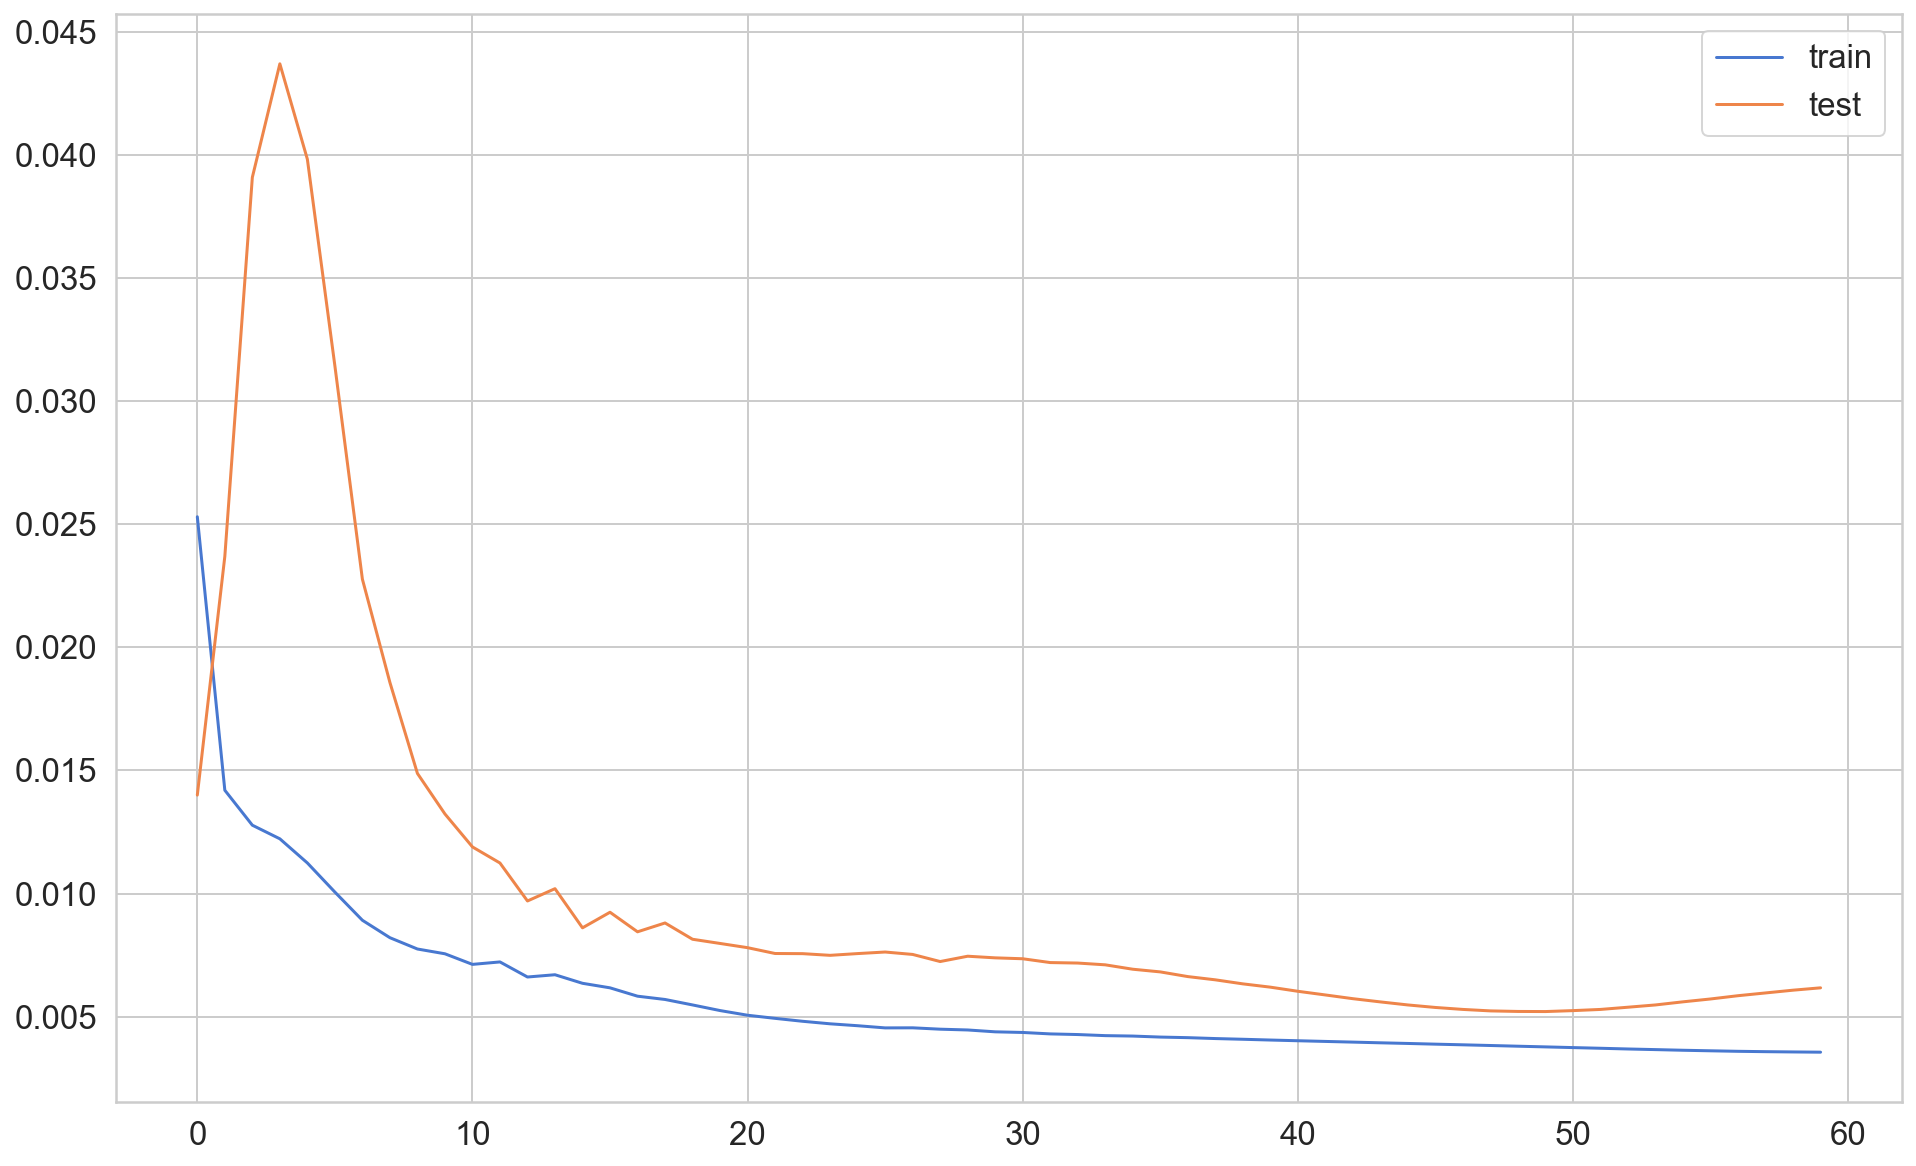

In [127]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

## Evaluation

We can plot the predictions over the true values from the Time Series. Let’s take some predictions from our model:

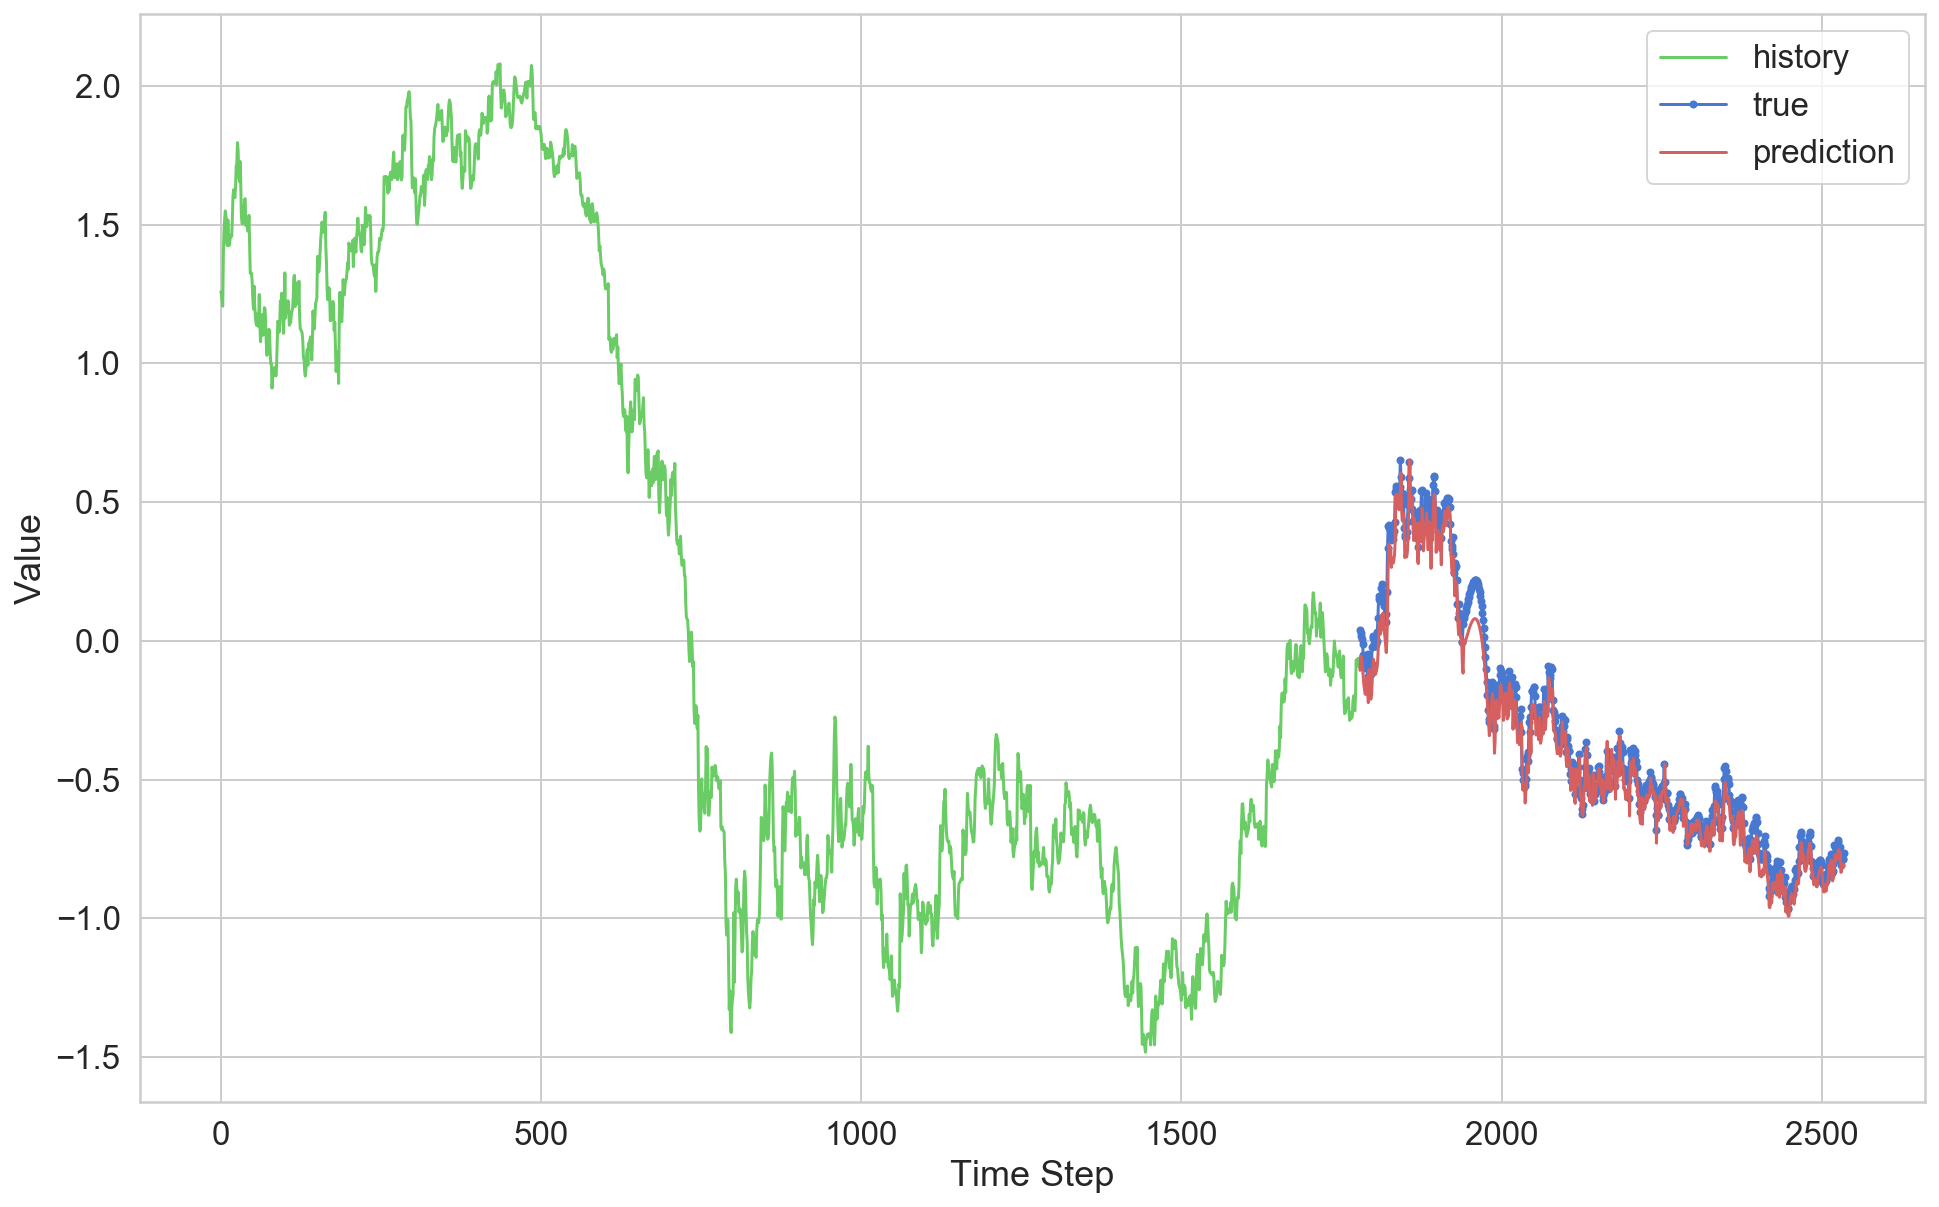

In [128]:
y_pred = model.predict(X_test)

plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Our predictions look really good on this scale. Let’s zoom in:

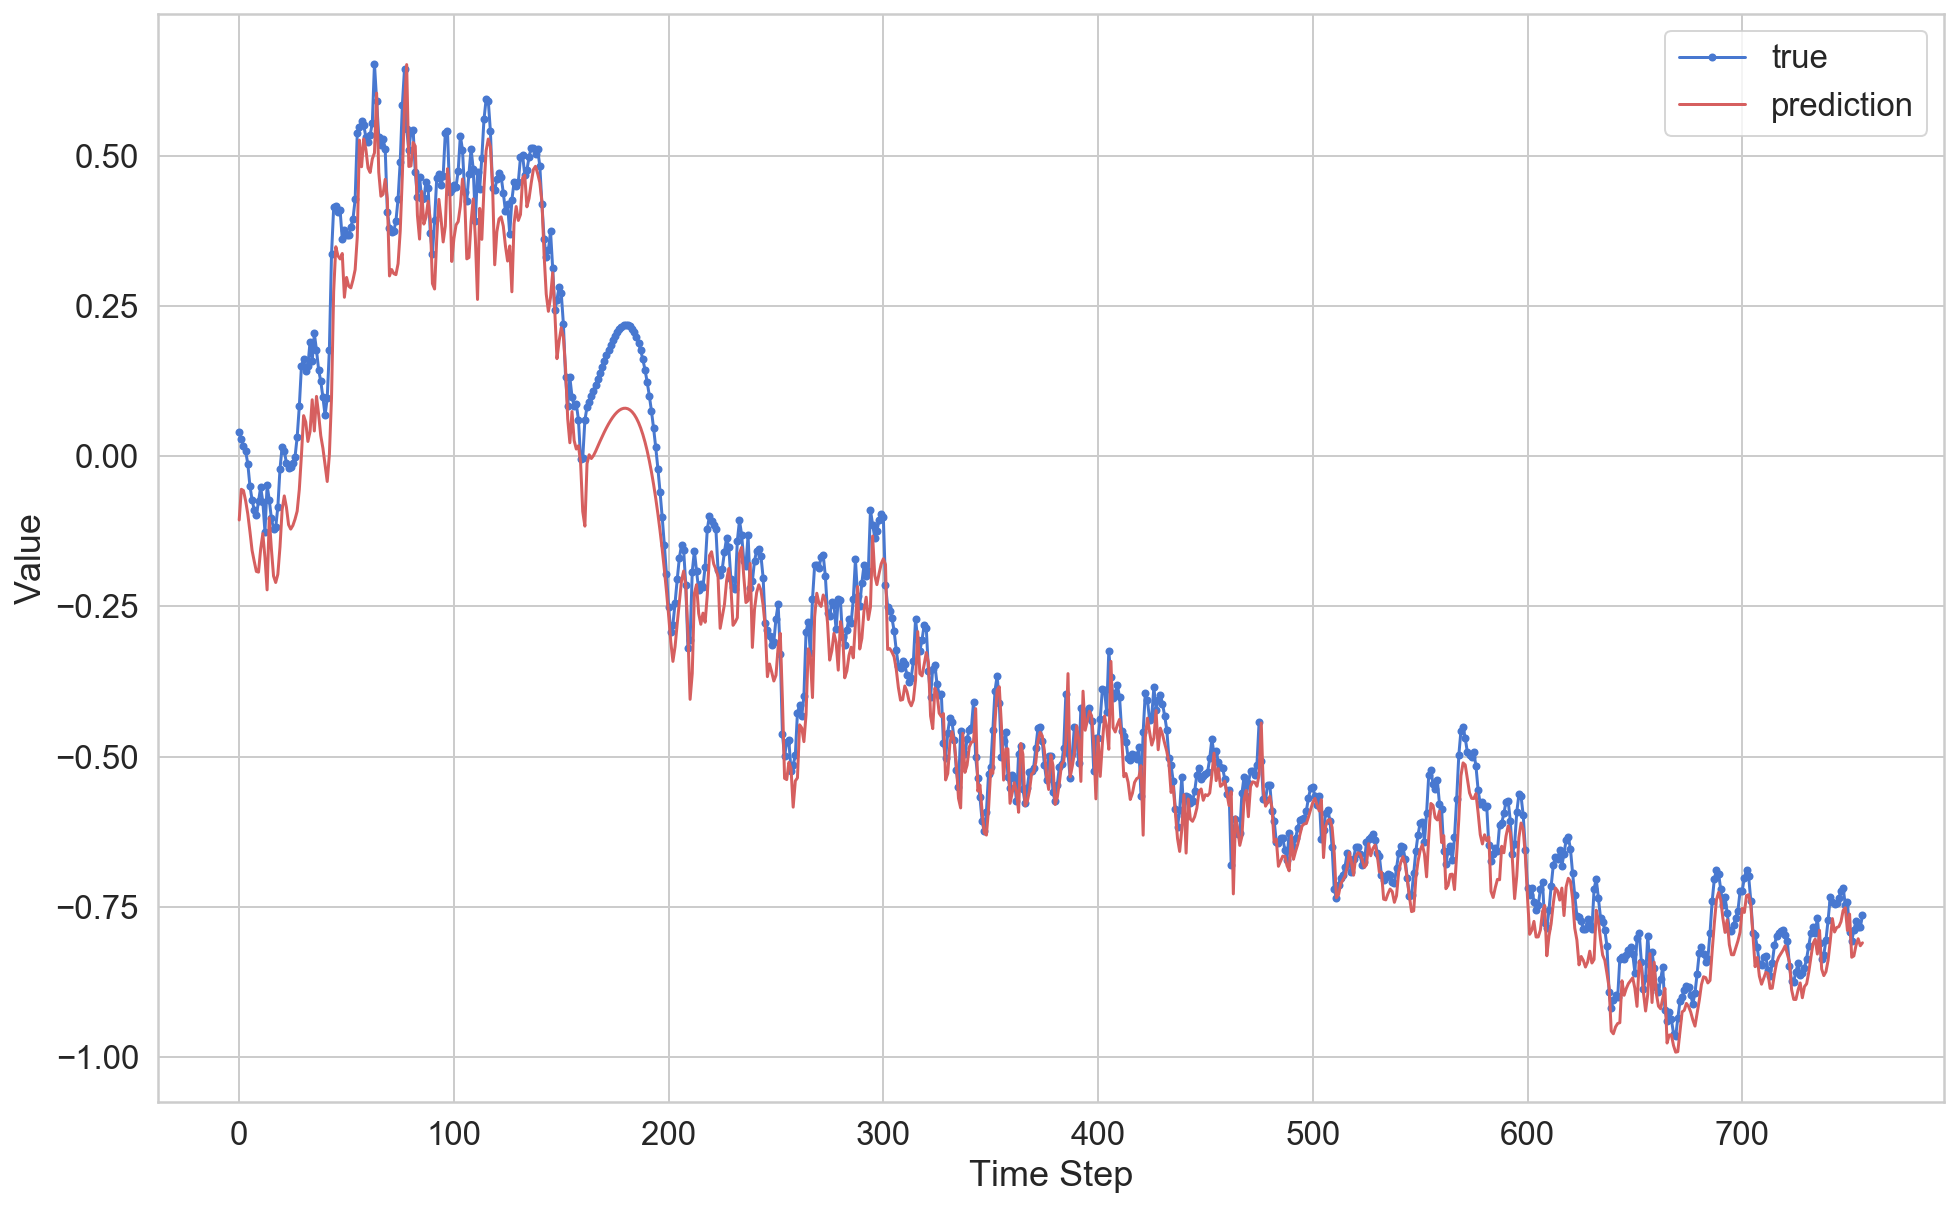

In [129]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

# Funciones para calcular la media móvil y la diferencia valor - media móvil

In [130]:
val_array = pairs.values
def mm_array(arr, mm_step=10):
    arr = arr.transpose() / mm_step
    mm = np.zeros(arr.shape[0]*(arr.shape[1]-mm_step), dtype=np.float64).reshape(arr.shape[0], arr.shape[1]-mm_step)
    for i in range(len(arr)):
        for j in range(len(arr[i])-mm_step):
            mm[i][j] = sum(arr[i][j:(j+mm_step)])
    return mm.transpose()

def diff_array(vals, mm):
    return vals[vals.shape[0]-mm.shape[0]:] - mm

mm_step = 20
diff = diff_array(val_array, mm_array(val_array, mm_step))

In [131]:
mm_pairs = pd.DataFrame(diff, index=pairs.iloc[mm_step:].index, columns=pairs.columns)
train_size_mm = int(len(mm_pairs) * 0.7)
test_size_mm = len(mm_pairs) - train_size_mm
train_mm, test_mm = mm_pairs.iloc[0 : train_size_mm], mm_pairs.iloc[train_size_mm : len(mm_pairs)]
# print(len(train), len(test)  # After dividing the dataset, reshape
input_time_steps = 5
output_time_steps = 1
target = 'EUR/USD Close';

# reshape to [samples, time_steps, n_features]

X_train_mm, y_train_mm = create_dataset_nsteps(train_mm, train_mm[target], input_time_steps, output_time_steps)
X_test_mm, y_test_mm = create_dataset_nsteps(test_mm, test_mm[target], input_time_steps, output_time_steps)

print(X_train_mm.shape, y_train_mm.shape)

model_mm = keras.Sequential()
model_mm.add(keras.layers.LSTM(128, input_shape=(X_train_mm.shape[1], X_train_mm.shape[2])))
model_mm.add(keras.layers.Dense(output_time_steps))
model_mm.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))

history_mm = model_mm.fit(
    X_train_mm, y_train_mm, 
    epochs=60, 
    batch_size=2, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=False
)

(1765, 5, 4) (1765, 1)
Train on 1588 samples, validate on 177 samples
Epoch 1/60
1588/1588 [==============================] - 5s 3ms/sample - loss: 0.0069 - val_loss: 0.0025
Epoch 2/60
1588/1588 [==============================] - 3s 2ms/sample - loss: 0.0033 - val_loss: 0.0021
Epoch 3/60
1588/1588 [==============================] - 3s 2ms/sample - loss: 0.0030 - val_loss: 0.0020
Epoch 4/60
1588/1588 [==============================] - 3s 2ms/sample - loss: 0.0030 - val_loss: 0.0020
Epoch 5/60
1588/1588 [==============================] - 3s 2ms/sample - loss: 0.0030 - val_loss: 0.0020
Epoch 6/60
1588/1588 [==============================] - 3s 2ms/sample - loss: 0.0030 - val_loss: 0.0020
Epoch 7/60
1588/1588 [==============================] - 3s 2ms/sample - loss: 0.0030 - val_loss: 0.0020
Epoch 8/60
1588/1588 [==============================] - 3s 2ms/sample - loss: 0.0030 - val_loss: 0.0021
Epoch 9/60
1588/1588 [==============================] - 3s 2ms/sample - loss: 0.0030 - val_loss: 0

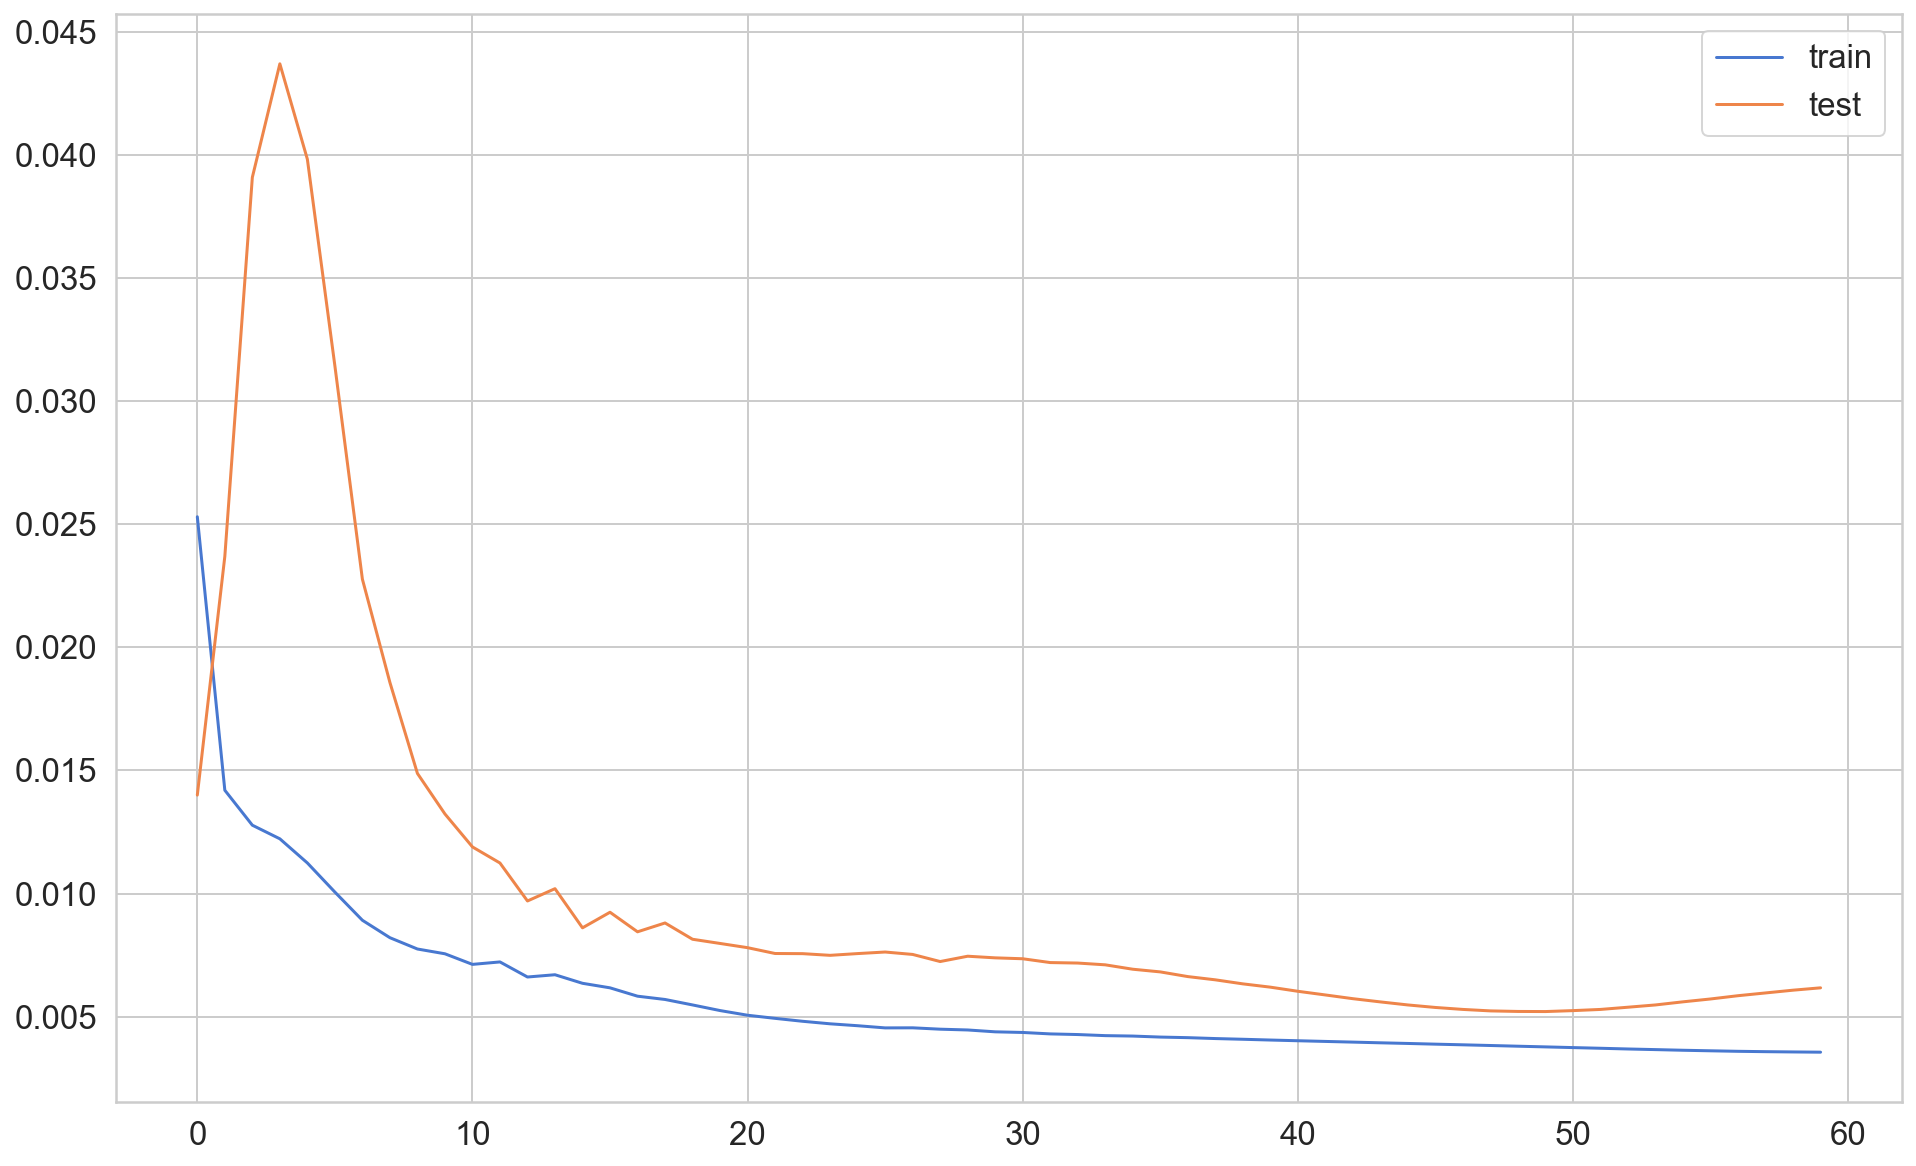

In [132]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

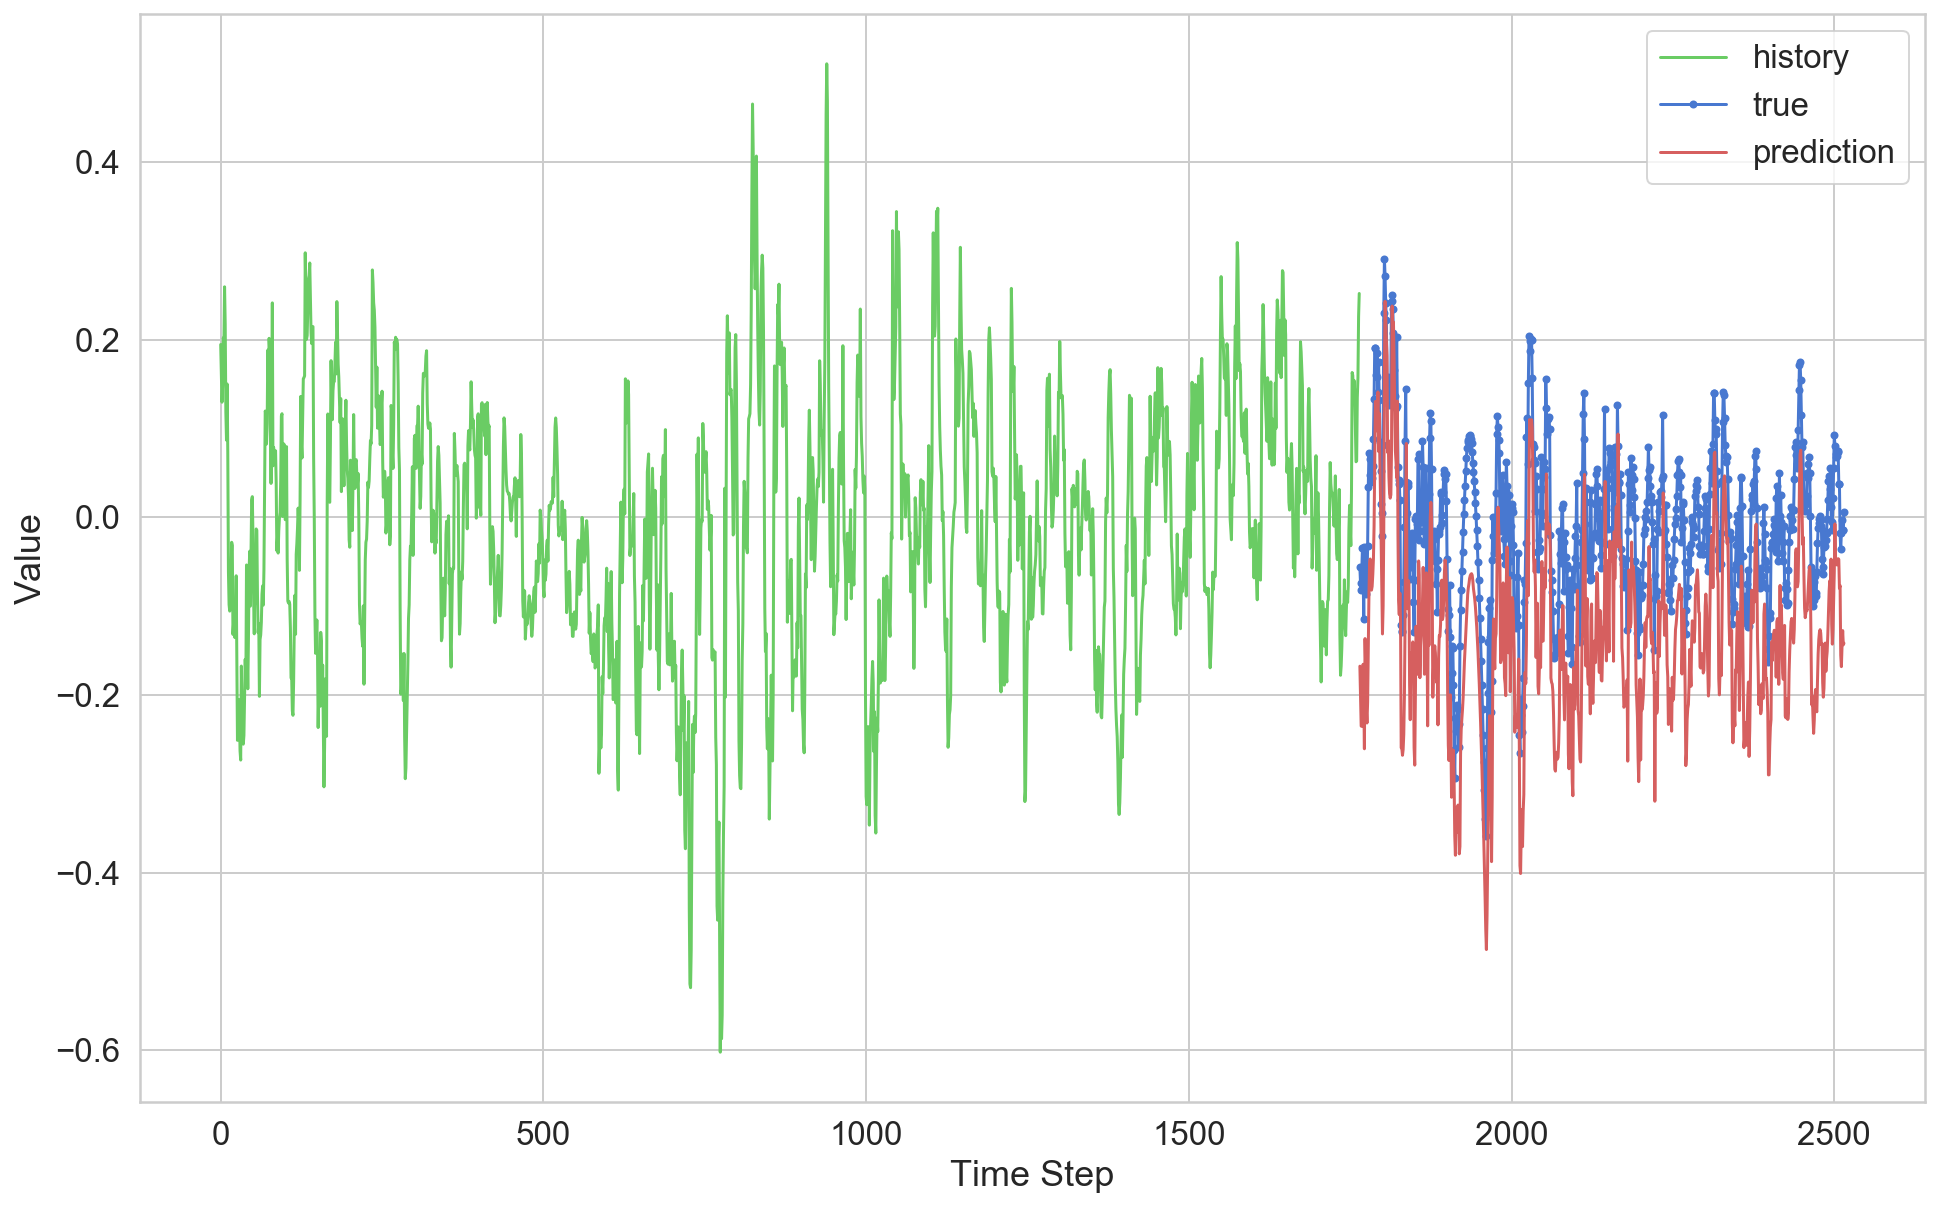

In [133]:
y_pred = model.predict(X_test_mm)

plt.plot(np.arange(0, len(y_train_mm)), y_train_mm, 'g', label="history")
plt.plot(np.arange(len(y_train_mm), len(y_train_mm) + len(y_test_mm)), y_test_mm, marker='.', label="true")
plt.plot(np.arange(len(y_train_mm), len(y_train_mm) + len(y_test_mm)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

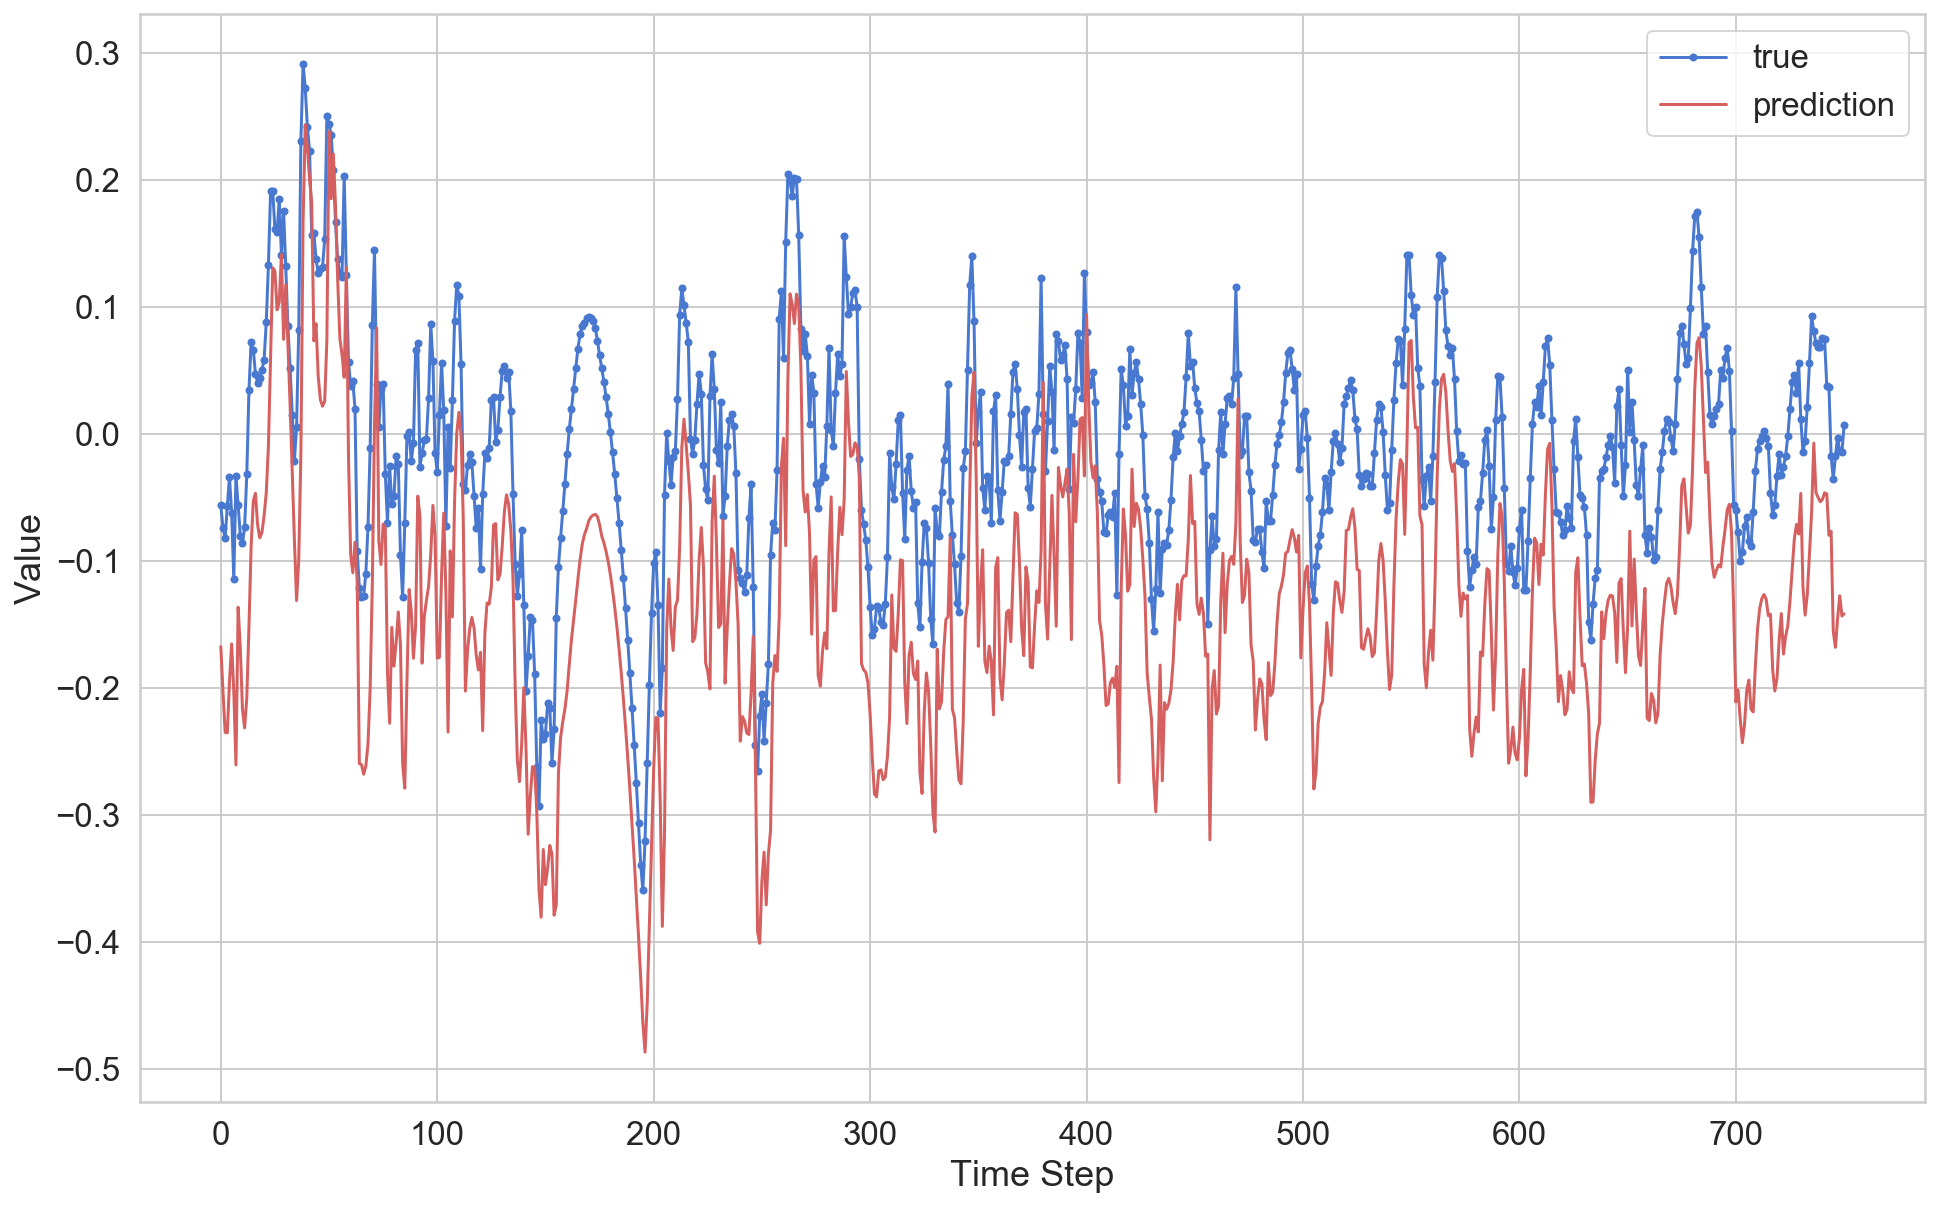

In [134]:
plt.plot(y_test_mm, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

## Can we use this function to predict many steps in the future?

We will try to feed the previous predictions of the model to "generate" a new set of values in the future of the time serie. Do you think it will work?

In [138]:
nSteps = X_test.shape[0]
y_pred = []

for i in range(0, nSteps//output_time_steps):
    xi = np.array([X_test[10 * i]])
    print((i, xi))
    y_pred = np.append(y_pred, model.predict(xi)[0])

plt.plot([yt[0] for yt in y_test[0:len(y_pred)]], marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

(0, array([[[ 0.1087143 ,  0.28845687,  0.28791584,  0.35812899],
        [ 0.09337392,  0.23655132,  0.30221133,  0.32090023],
        [ 0.03515689,  0.23304536,  0.33880357,  0.28088996],
        [-0.0271108 ,  0.30376477,  0.38476733,  0.27737422],
        [-0.00501581,  0.34512895,  0.41598799,  0.31370356]]]))
(1, array([[[-0.04920578,  0.44253492,  0.28069845,  0.33538398],
        [-0.07230509,  0.39850208,  0.36742251,  0.29729676],
        [-0.08937849,  0.51458866,  0.42292591,  0.34593121],
        [-0.09841734,  0.5679618 ,  0.43159832,  0.36702567],
        [-0.07511636,  0.56659588,  0.41982782,  0.38137363]]]))
(2, array([[[-0.10343893,  0.45854686,  0.42552764,  0.30784399],
        [-0.12018877,  0.47782053,  0.47448246,  0.30782639],
        [-0.11826094,  0.45100144,  0.45841516,  0.29517808],
        [-0.0843569 ,  0.44386925,  0.43680177,  0.31311761],
        [-0.02108489,  0.49724239,  0.44113797,  0.3816746 ]]]))
(3, array([[[-0.01104172,  0.53460359,  0.3075829

        [-0.24839061,  0.33978889,  0.59153739,  0.1531371 ]]]))
(30, array([[[-0.11348211,  0.43719761,  0.47235863,  0.29026528],
        [-0.1351635 ,  0.4326751 ,  0.48009775,  0.27298251],
        [-0.1241205 ,  0.43565366,  0.49218001,  0.28105416],
        [-0.10645188,  0.45988119,  0.49750861,  0.30550016],
        [-0.09540439,  0.49057075,  0.50097757,  0.32952441]]]))
(31, array([[[-0.29024199,  0.62800658,  0.36395355,  0.26975677],
        [-0.32238015,  0.58263941,  0.38997077,  0.22639594],
        [-0.34849241,  0.67337374,  0.41165179,  0.25510784],
        [-0.35250968,  0.61199464,  0.4801638 ,  0.22053637],
        [-0.34045787,  0.60265434,  0.49403965,  0.22463807]]]))
(32, array([[[-0.27115996,  0.35847223,  0.59030336,  0.14553385],
        [-0.30530676,  0.3571379 ,  0.58770164,  0.12268151],
        [-0.32366547,  0.35500346,  0.58668302,  0.11003772],
        [-0.30609251,  0.34487457,  0.57374878,  0.1166535 ],
        [-0.28120313,  0.34913193,  0.53479996

(56, array([[[-0.52280243, -0.15191932,  0.75167425, -0.27432645],
        [-0.54537204, -0.1232522 ,  0.75681651, -0.27412855],
        [-0.55337319, -0.09920242,  0.7724239 , -0.26639407],
        [-0.53931274, -0.09920242,  0.79237044, -0.25701876],
        [-0.57848112, -0.10053675,  0.83746695, -0.28338683]]]))
(57, array([[[-0.67288697, -0.11121138,  0.87736002, -0.34842808],
        [-0.63472291, -0.15524422,  0.80451181, -0.34491234],
        [-0.5714509 , -0.26999646,  0.71171706, -0.36249105],
        [-0.49813572, -0.24998154,  0.72732739, -0.30506725],
        [-0.45723176, -0.21564344,  0.73594059, -0.26209648]]]))
(58, array([[[-0.49311413, -0.20061139,  0.61978955, -0.27869917],
        [-0.5160948 , -0.14913987,  0.6229138 , -0.26729073],
        [-0.55543687, -0.10242403,  0.64720691, -0.2686827 ],
        [-0.57948544, -0.11388004,  0.65968262, -0.28983236],
        [-0.57647249, -0.18593377,  0.63973608, -0.32440384]]]))
(59, array([[[-0.65280062, -0.08052183,  0.624

IndexError: index 760 is out of bounds for axis 0 with size 757

In [137]:
int(nSteps/time_steps)

NameError: name 'time_steps' is not defined

In [ ]:
y_test

What about adding some noise?

In [ ]:
nSteps = X_test.shape[0]
xi = np.array([X_test[0]])
y_pred = []

for i in range(nSteps):
    yi = model.predict(xi)[0]
    y_pred.append(yi)
    xi = np.reshape([np.insert(xi[0][1:], time_steps - 1, yi + np.random.normal(scale=0.5))], (1, time_steps, 1))

plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

TypeError: can't pickle _thread.RLock objects